In [7]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

# 设置绘图风格
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS'] # 适配中文显示
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题


In [8]:

# ==========================================
# 1. 数据加载与预处理函数
# ==========================================
def load_and_process_data(filepath):
    """
    读取 JSON 并转换为 Pandas DataFrame。
    由于数据是聚合格式 (Turn -> Diff -> Count)，我们需要将其展平。
    """
    print(f"正在加载数据: {filepath} ...")
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    meta = data.get('meta_info', {})
    print(f"元数据: {json.dumps(meta, indent=2)}")
    
    # 辅助函数：将嵌套字典转换为列表
    def parse_structure(nested_data, color_label):
        records = []
        for turn_str, diff_map in nested_data.items():
            turn = int(turn_str)
            for diff_str, count in diff_map.items():
                # 还原真实兵力差： JSON中存储的是 int(diff * 10)
                material_diff = int(diff_str) / 10.0
                records.append({
                    "Turn": turn,
                    "Material_Diff": material_diff,
                    "Count": count,
                    "Color": color_label
                })
        return records

    # 解析白方和黑方的投降数据
    white_records = parse_structure(data['white_resigned'], 'White (Resigned)')
    black_records = parse_structure(data['black_resigned'], 'Black (Resigned)')
    
    # 合并为 DataFrame
    df = pd.DataFrame(white_records + black_records)
    
    return df, meta


In [9]:

# ==========================================
# 2. 可视化：抗压能力分布 (Resignation Distribution)
# ==========================================
def plot_resignation_distribution(df, title_suffix=""):
    """
    绘制黑白双方在不同兵力差下的投降频率分布。
    这能直观展示“由于落后多少分而崩溃”。
    """
    plt.figure(figsize=(12, 6))
    
    # 我们需要根据 Count 权重来绘制分布
    # 方法：将数据聚合，计算每个 Material_Diff 的总 Count
    
    # 1. 聚合数据
    df_agg = df.groupby(['Color', 'Material_Diff'])['Count'].sum().reset_index()
    
    # 2. 为了平滑曲线，我们只看兵力差在 -15 到 +15 之间的数据
    mask = (df_agg['Material_Diff'] >= -15) & (df_agg['Material_Diff'] <= 15)
    filtered_data = df_agg[mask]
    
    # 3. 绘制折线图 (也就是分布密度的轮廓)
    sns.lineplot(
        data=filtered_data, 
        x='Material_Diff', 
        y='Count', 
        hue='Color',
        palette={'White (Resigned)': '#e74c3c', 'Black (Resigned)': '#34495e'},
        linewidth=2.5
    )
    
    # 添加辅助线
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label='均势 (0)')
    plt.axvline(x=-3, color='orange', linestyle=':', alpha=0.5, label='丢一子 (-3)')
    plt.axvline(x=-5, color='purple', linestyle=':', alpha=0.5, label='丢一车 (-5)')
    
    plt.title(f'投降时的兵力差分布 (Material Difference at Resignation) {title_suffix}', fontsize=14)
    plt.xlabel('兵力优势 (正数代表自身优势，负数代表劣势)', fontsize=12)
    plt.ylabel('投降频次 (Count)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 标注关键区域
    plt.text(-4, plt.gca().get_ylim()[1]*0.5, '崩溃区\n(Blunder Zone)', color='red', ha='center')
    
    plt.tight_layout()
    plt.show()


In [10]:

# ==========================================
# 3. 可视化：投降热力图 (Resignation Heatmap)
# ==========================================
def plot_resignation_heatmap(df, target_color, max_turn=80):
    """
    绘制特定一方的投降热力图：X轴=回合，Y轴=兵力差。
    """
    # 筛选特定颜色的数据
    subset = df[df['Color'] == target_color].copy()
    
    # 过滤范围
    subset = subset[(subset['Turn'] <= max_turn) & 
                    (subset['Material_Diff'] >= -12) & 
                    (subset['Material_Diff'] <= 4)]
    
    # 创建透视表 (Pivot Table) -> 矩阵
    # index=Material_Diff, columns=Turn, values=Count
    matrix = subset.pivot_table(index='Material_Diff', columns='Turn', values='Count', aggfunc='sum').fillna(0)
    
    # 倒序排列 Y 轴，让正数在上面
    matrix = matrix.sort_index(ascending=False)
    
    plt.figure(figsize=(14, 8))
    
    # 使用 LogNorm 让色彩分布更均匀（避免少数极大值掩盖了细节）
    sns.heatmap(
        matrix, 
        cmap='Spectral_r', 
        norm=LogNorm(vmin=matrix.max().max()*0.001, vmax=matrix.max().max()),
        cbar_kws={'label': '投降频次 (Log Scale)'}
    )
    
    plt.title(f'{target_color} 投降热力图 (Resignation Density)', fontsize=16)
    plt.xlabel('回合数 (Turn)', fontsize=12)
    plt.ylabel('兵力差 (Material Diff)', fontsize=12)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()


正在加载数据: ../output/chess_resign/final_resignation_stats.json ...
元数据: {
  "note": "material_diff scaled by 10",
  "resignation_count": 64413415,
  "source_file": "../dataset/lichess_db_standard_rated_2025-11.pgn",
  "total_games": 90633152,
  "window_size": 5
}

数据概览:
总记录数 (Rows): 56709
总投降局数 (Sum Count): 64413415


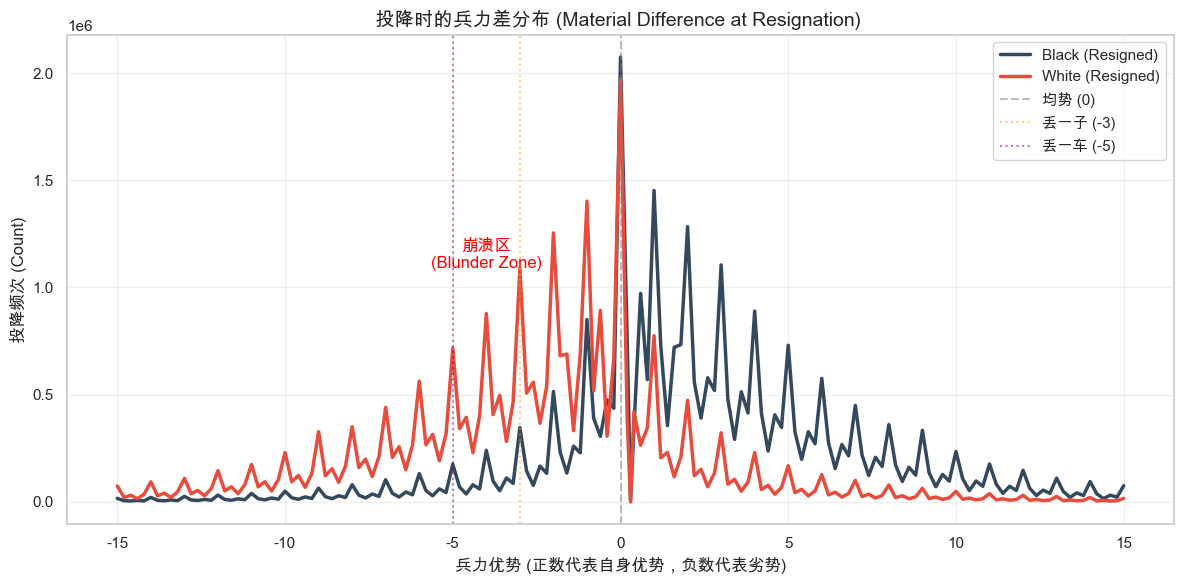

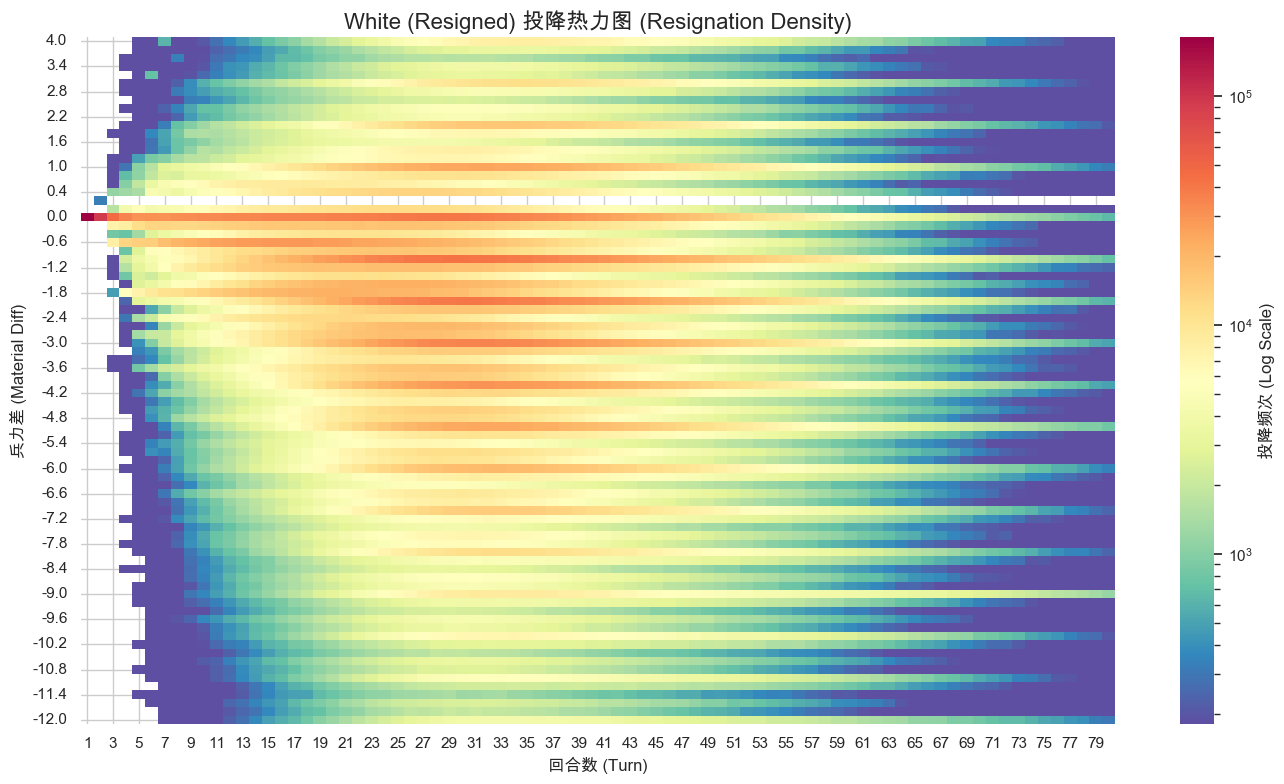

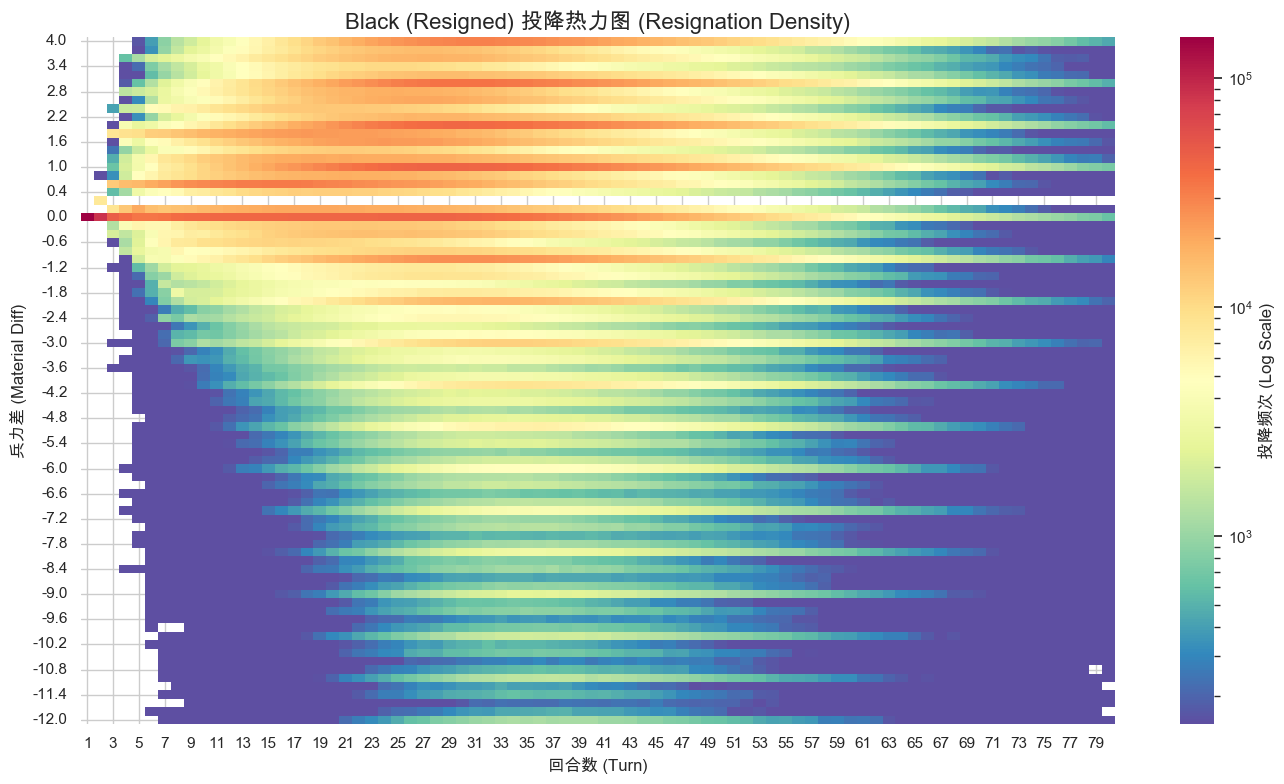

In [11]:

# ==========================================
# 主执行逻辑
# ==========================================

# 1. 加载文件
file_path = '../output/chess_resign/final_resignation_stats.json' # 请根据实际路径修改
try:
    df, meta = load_and_process_data(file_path)
    
    print(f"\n数据概览:")
    print(f"总记录数 (Rows): {len(df)}")
    print(f"总投降局数 (Sum Count): {df['Count'].sum()}")
    
    # 2. 绘制对比分布图
    plot_resignation_distribution(df)
    
    # 3. 绘制热力图 (分别查看黑白)
    plot_resignation_heatmap(df, 'White (Resigned)')
    plot_resignation_heatmap(df, 'Black (Resigned)')

except FileNotFoundError:
    print(f"错误：找不到文件 {file_path}。请确保 C++ 程序已运行并生成了 JSON。")
except Exception as e:
    print(f"发生错误: {e}")

这三张图表非常精彩！它们完美地将“国际象棋”这一复杂的博弈过程降维成了可视化的心理学统计。

通过对比这三张图（两张热力图，一张分布折线图），我们可以得出关于**投降心理阈值**、**时间对希望的侵蚀**以及**黑白双方心态差异**的几个极具洞察力的结论。

以下是详细的深度分析：

### 1. 投降的“离散阶梯”：心理崩溃的物理单位
**（基于图3：投降时的兵力差分布）**

最引人注目的是分布图中的**锯齿状（Jagged）特征**。这揭示了人类玩家评估局势的“量子化”思维：

* **“三、五、九”法则**：
    * 曲线的峰值非常精确地出现在 **±3.0**（丢马/象）、**±5.0**（丢车）和 **±9.0**（丢后）的位置。
    * 这说明绝大多数玩家的心理防线是建立在**整子（Piece）**上的。
    * **有趣的低谷**：注意 -2.0 或 -4.0 处的低谷。这说明：如果只是丢了两个兵（-2），很多玩家会选择“苟活”；但一旦上升到丢一个半子（-3），心理防线会瞬间崩塌。
* **0.0 的超级尖峰（The "Mate-in-N" Spike）**：
    * 无论是黑方还是白方，在 **兵力差为 0** 时投降的频次都是极高的（灰色虚线处）。
    * **解读**：这代表了“局面性投降”或“不可避免的将杀”。虽然兵力相等，但王被关进死胡同，或者下一步必然丢后。这部分数据证明了高水平对局中，**“势”比“质”更重要**。

---

### 2. 希望的时间衰减率：绝望的“对角线”
**（基于图1 & 图2：热力图分析）**

两张热力图都呈现出清晰的**三角形（漏斗形）结构**，这直观地展示了“回合数”如何改变玩家对“劣势”的容忍度。

* **开局的盲目自信（Turn 1-10）**：
    * 在左侧区域，投降点主要集中在 **±9 (丢后)** 和 **±5 (丢车)** 的极端位置。
    * **心理学**：在开局阶段，除非发生灾难性失误（Blunder），否则即使微小的劣势（如落后1-2兵），玩家也会认为“棋盘还大，还有变数”，拒绝投降。
* **残局的零容忍（Turn 50+）**：
    * 随着回合数增加（向右移动），高亮区域迅速向 **0轴** 收敛。
    * 到了 60 回合以后，**-1.0（少一个兵）** 甚至 **0.0** 的区域变成了深红色。
    * **心理学**：在残局阶段，计算变得穷尽。少一个兵往往意味着必败（Theoretical Loss）。时间剥夺了翻盘的复杂性，也剥夺了玩家的希望。

---

### 3. 黑白对抗：谁的心态更易崩？
**（对比分析）**

这里有一个非常有趣的数据现象。让我们修正图3的X轴逻辑（通常 X轴=白方-黑方）：
* **红线（白方投降）**：峰值主要在负值区间（-3, -5...），意味着白方亏分时投降。
* **蓝黑线（黑方投降）**：峰值主要在正值区间（+3, +5...），意味着白方赢分（即黑方亏分）时投降。

**关于“抗压能力”的洞察：**

1.  **对称性中的不对称**：
    * 乍看之下，红线左侧和蓝线右侧非常对称。这说明**由于丢子导致的挫败感是普世的**，与执白执黑关系不大。
    * 但细看 **峰值高度**：蓝线（黑方投降）在 +3 和 +5 处的峰值，似乎比红线（白方投降）在 -3 和 -5 处的峰值**略高且更尖锐**。
    * **推论**：这可能源于**幸存者偏差**。因为白方有先行优势，统计上白方占优的局数本来就多，所以黑方处于劣势的总样本量更大，导致投降绝对数量更多。

2.  **“赢势投降”的怪象（Rage Quit / Life Happens）**：
    * 观察图3的**尾部**：红线在正数区（白方领先）依然有非零的分布；蓝线在负数区（黑方领先）也有分布。
    * **原因**：这通常不是因为局势判断，而是现实因素（如：妈妈喊你吃饭了、网络断线、或者在优势局面下走了一步滑标，虽然引擎评估还没变但心态炸了）。

3.  **白方的“玻璃心”假设**：
    * 看热力图（图1 vs 图2）：白方的热力图在 **Turn < 10** 的区域，似乎比黑方在同区域的投降点更稀疏一些？
    * 其实反过来思考：**白方作为先行者，心理预设是“进攻”和“获胜”。**
    * 当白方陷入 -2 或 -3 的劣势时，这种与“心理预设”的巨大落差（Cognitive Dissonance）可能会导致比黑方更强烈的挫败感。黑方作为后手，开局本身就是防御姿态，对微弱劣势的心理准备可能更充分。

### 4. 总结与建议

**一句话总结**：
**投降不是一个线性函数，而是一个由“子力价值”定义阶梯、由“回合数”定义斜率的动态阈值模型。**

**后续可挖掘的有趣点**：
1.  **ELO 分段差异**：高手和新手在这张图上的表现截然不同。新手的热力图会更弥散（不到将死不投降），高手的热力图会高度收敛于 0 轴（大局已定即投降）。
2.  **翻盘率分析**：既然很多人在 -3 时投降，那么那些在 -3 时**没有投降**的人，最后赢的概率是多少？这将计算出“韧性的真实价值”。

这组可视化做得非常棒，清晰地讲述了数据背后的故事！